# Task :->  Use of Machine Learning Library (MLlib) :- Spark’s machine learning (ML) library for Clustering

### Model :-> K-Means

### Dataset :-> Auto.csv


In [1]:
# For Local Machine sparkcontext creation
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# In cloud the sparkcontext is created as "sc" 
# ex:- IBM watson 
# python :- 3.6
# spark :- 2.3.3

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200303161216-0000
KERNEL_ID = 9114ccfc-5dcb-45b8-80b8-47fc9d2fffce


In [2]:
sc.version

'2.3.3'

In [3]:
# The following code contains the credentials for a file in your IBM Cloud Object Storage.

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'XXXX',
    'service_id': 'XXXX',
    'iam_service_endpoint': 'XXXX',
    'api_key': 'XXXX'
}

configuration_name = 'os_0a7faf2d576d4d0e985305b42aae4ce7_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')


In [5]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'XXXX',
    'IBM_API_KEY_ID': 'XXXX',
    'ENDPOINT': 'XXX',
    'IBM_AUTH_ENDPOINT': 'XXXX',
    'BUCKET': 'XXXX',
    'FILE': 'Auto.csv'
}
data_link = cos.url('Auto.csv', 'sparktry-donotdelete-pr-adbnjs9sf1yuav')

In [7]:
df_auto = spark.read.csv(data_link, header=True, inferSchema=True)

In [8]:
df_auto.show()

+----+---------+------------+----------+------+------------+----+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|year|origin|                name|
+----+---------+------------+----------+------+------------+----+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|  70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|  70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|  70|     1|  plymouth satellite|
|16.0|        8|       304.0|       150|  3433|        12.0|  70|     1|       amc rebel sst|
|17.0|        8|       302.0|       140|  3449|        10.5|  70|     1|         ford torino|
|15.0|        8|       429.0|       198|  4341|        10.0|  70|     1|    ford galaxie 500|
|14.0|        8|       454.0|       220|  4354|         9.0|  70|     1|    chevrolet impala|
|14.0|        8|       440.0|       215|  4312|         8.5|

In [9]:
df_auto.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- displacement: double (nullable = true)
 |-- horsepower: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- acceleration: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- origin: integer (nullable = true)
 |-- name: string (nullable = true)



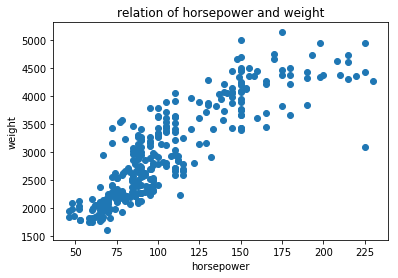

In [20]:
# we use only dispacement,horsepower and weight
# sampling and plotting the dataframe
import pandas as pd
import matplotlib.pyplot as plt
x='horsepower'
y='weight'
sampled_data = df_auto.select(x,y).sample(False, 0.8).toPandas()
plt.scatter(sampled_data.horsepower,sampled_data.weight)
plt.xlabel(x)
plt.ylabel(y)
plt.title('relation of horsepower and weight')
plt.show()

In [22]:
# assembling the columns
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [x,y], outputCol = 'features')
v_df = vectorAssembler.transform(df_auto)
v_df = v_df.select(['features'])
v_df.show(10)

+--------------+
|      features|
+--------------+
|[130.0,3504.0]|
|[165.0,3693.0]|
|[150.0,3436.0]|
|[150.0,3433.0]|
|[140.0,3449.0]|
|[198.0,4341.0]|
|[220.0,4354.0]|
|[215.0,4312.0]|
|[225.0,4425.0]|
|[190.0,3850.0]|
+--------------+
only showing top 10 rows



# K-Means Clustering

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [30]:
# creating objects with four centers and fitting
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(v_df)

In [31]:
# predicting centers
predictions = model.transform(v_df)

In [32]:
predictions.show(5)

+--------------+----------+
|      features|prediction|
+--------------+----------+
|[130.0,3504.0]|         1|
|[165.0,3693.0]|         1|
|[150.0,3436.0]|         1|
|[150.0,3433.0]|         1|
|[140.0,3449.0]|         1|
+--------------+----------+
only showing top 5 rows



In [33]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7522590533965963


In [34]:
# Shows the center points
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  72.94852941 2107.70588235]
[ 115.57954545 3489.01136364]
[ 165.13043478 4366.5942029 ]
[  95.61616162 2749.86868687]


In [35]:
predictions.select('features').show(5)

+--------------+
|      features|
+--------------+
|[130.0,3504.0]|
|[165.0,3693.0]|
|[150.0,3436.0]|
|[150.0,3433.0]|
|[140.0,3449.0]|
+--------------+
only showing top 5 rows



In [36]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

In [37]:

split1_udf = udf(lambda value: value[0].item(), FloatType())
split2_udf = udf(lambda value: value[1].item(), FloatType())

In [38]:
# unpacking features column so that we can plot them 
predictions=predictions.withColumn('x', split1_udf('features')).withColumn('y', split2_udf('features'))

In [39]:
predictions.show(4)

+--------------+----------+-----+------+
|      features|prediction|    x|     y|
+--------------+----------+-----+------+
|[130.0,3504.0]|         1|130.0|3504.0|
|[165.0,3693.0]|         1|165.0|3693.0|
|[150.0,3436.0]|         1|150.0|3436.0|
|[150.0,3433.0]|         1|150.0|3433.0|
+--------------+----------+-----+------+
only showing top 4 rows



In [40]:
# sampling data to plot 
data = predictions.select('x','y','prediction').sample(False, 0.8).toPandas()

In [41]:
x_cord = [[],[],[],[]]
y_cord = [[],[],[],[]]

In [42]:
cx = []
cy = []
for center in model.clusterCenters():
    cx.append(center[0])
    cy.append(center[1])

In [43]:
for i in range(len(data)):
    x_cord[data.loc[i,'prediction']].append(data.loc[i,'x'])
    y_cord[data.loc[i,'prediction']].append(data.loc[i,'y'])

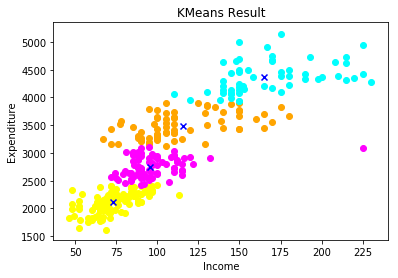

In [45]:
# plotting the clusters
plt.scatter(x_cord[0],y_cord[0],c='yellow')
plt.scatter(x_cord[1],y_cord[1],c='orange')
plt.scatter(x_cord[2],y_cord[2],c='cyan')
plt.scatter(x_cord[3],y_cord[3],c='magenta')
plt.scatter(cx,cy,c='blue',marker='x')
plt.xlabel('Income')
plt.ylabel('Expenditure')
plt.title('KMeans Result')
plt.show()

# Bisecting k-means

In [53]:
from pyspark.ml.clustering import BisectingKMeans

x="horsepower"
y="weight"
sampled_data_df = df_auto.select(x,y)
# Trains a bisecting k-means model.
# bkm = BisectingKMeans().setK(4).setSeed(1)
# model = bkm.fit(sampled_data)

In [56]:
df_auto_ms = spark.read.csv(data_link, header=True, inferSchema=True)

In [57]:
df = df_auto_ms.drop("mpg","cylinders","displacement","acceleration","year","origin")

In [59]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['horsepower','weight'], outputCol = 'features')
v_df = vectorAssembler.transform(df)
v_df = v_df.select(['features'])
v_df.show(3)

+--------------+
|      features|
+--------------+
|[130.0,3504.0]|
|[165.0,3693.0]|
|[150.0,3436.0]|
+--------------+
only showing top 3 rows



In [60]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(v_df)

In [63]:
# Evaluate clustering.
cost = model.computeCost(v_df)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 71600415.82583654


In [64]:
# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[  82.59322034 2381.38135593]
[ 137.56410256 3879.53205128]


# **<center>Thanks!</center>**